# Image anomaly detection

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
import os
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from cal_Metric import *
from tqdm import tqdm

In [2]:
TEST_DATA_PATH =  "test_data/"
GAUSS_NOISE_PATH =  "noise_data_0.4_0.4/gauss"
SP_NOISE_PATH =  "noise_data_0.4_0.4/s&p"
OTHERS_PATH = "others_data"

In [3]:
img_size = 256
b_size = 4
test_transform = transforms.Compose([
                                    transforms.Resize((img_size,img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
                                    ])

crop_transform = transforms.Compose([
                                    transforms.Resize((1000,1000)),
                                    transforms.RandomCrop((750,750)),
                                    transforms.Resize((img_size,img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
                                    ])
test_data = datasets.ImageFolder(root=TEST_DATA_PATH,transform=test_transform)
gauss_data = datasets.ImageFolder(root=GAUSS_NOISE_PATH,transform=test_transform)
sp_data = datasets.ImageFolder(root=SP_NOISE_PATH,transform=test_transform)
others_data = datasets.ImageFolder(root=OTHERS_PATH,transform=test_transform)
crop_data = datasets.ImageFolder(root=TEST_DATA_PATH,transform=crop_transform)



test_data_loader  = data.DataLoader(test_data, batch_size=b_size, shuffle=False, num_workers=4) 
gauss_data_loader  = data.DataLoader(gauss_data, batch_size=b_size, shuffle=False, num_workers=4) 
sp_data_loader  = data.DataLoader(sp_data, batch_size=b_size, shuffle=False, num_workers=4) 
others_data_loader  = data.DataLoader(others_data, batch_size=b_size, shuffle=False, num_workers=4) 
crop_data_loader  = data.DataLoader(crop_data, batch_size=b_size, shuffle=False, num_workers=4) 

In [4]:
def test(model,data_loader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        correct = 0
        bs = test_data_loader.batch_size
        result = []
        Target = []
        Pred = []
        for i, (data, target) in enumerate(test_data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            arr = pred.data.cpu().numpy()[0][0]
            target = target.data.cpu().numpy()[0]
            
            for j in range(pred.size()[0]):
                file_name = test_data.samples[i*bs+j][0].split('/')[-1]
                result.append((file_name,pred[j].cpu().numpy()[0]))
                Target.append(target)
                Pred.append(arr)
    return result,Target,Pred

In [5]:
def get_max_softmax(model,data_loader,T):   
    with torch.no_grad():
        model.eval()
        bs = data_loader.batch_size
        Output_prob = []
        for i, (datas, target) in enumerate(data_loader ):
                datas, target = datas.to(device), target.to(device)
                output = model(datas)
                for out in output:
                    out = out.data.cpu().numpy()
                    out = out/T
                    output_prob = softmax(out)
                    Output_prob.append(output_prob.max())
    return np.array(Output_prob)

In [6]:
def energy_function(model,data_loader,T):
    with torch.no_grad():
        model.eval()
        Energy = []
        for i, (datas, target) in enumerate(data_loader ):
                datas, target = datas.to(device), target.to(device)
                output = model(datas)
                for out in output:
                    out = out.data.cpu().numpy()
                    out = T*np.log10(np.sum(np.exp(out/T)))
                    Energy.append(out)
        Energy = np.array(Energy)
    return np.array(Energy)

In [7]:
# https://github.com/facebookresearch/odin/tree/master/code

def ODIN(model,data_loader,temper,noiseMagnitude1):
    T = 1
    model.eval()
    ODIN_out = []
    for i, (datas, target) in enumerate(data_loader):
            datas, target = datas.to(device), target.to(device)
            inputs = Variable(datas, requires_grad = True)
            outputs = model(inputs)
            nnOutputs = outputs.data.cpu()
            nnOutputs = nnOutputs.numpy()
            nnOutputs = nnOutputs[0]
            nnOutputs = nnOutputs - np.max(nnOutputs)
            nnOutputs = np.exp(nnOutputs)/np.sum(np.exp(nnOutputs))
            # Using temperature scaling
            outputs = outputs / temper

            # Calculating the perturbation we need to add, that is,
            # the sign of gradient of cross entropy loss w.r.t. input
            maxIndexTemp = np.argmax(nnOutputs)
            labels = Variable(torch.LongTensor([maxIndexTemp]).to(device))
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            # Normalizing the gradient to binary in {0, 1}
            gradient =  torch.ge(inputs.grad.data, 0)
            gradient = (gradient.float() - 0.5) * 2
            # Normalizing the gradient to the same space of image
            gradient[0][0] = (gradient[0][0] )/(0.229)
            gradient[0][1] = (gradient[0][1] )/(0.224)
            gradient[0][2] = (gradient[0][2])/(0.225)
            # Adding small perturbations to images
            tempInputs = torch.add(inputs.data,  -noiseMagnitude1, gradient)
            outputs = model(Variable(tempInputs))
            outputs = outputs / temper
            # Calculating the confidence after adding perturbations
            nnOutputs = outputs.data.cpu()
            nnOutputs = nnOutputs.numpy()
            nnOutputs = nnOutputs[0]
            nnOutputs = nnOutputs - np.max(nnOutputs)
            nnOutputs = np.exp(nnOutputs)/np.sum(np.exp(nnOutputs))
            ODIN_out.append(nnOutputs)

    return np.max(ODIN_out,axis =1)

In [8]:
def ODIN(model,data_loader,temper,noiseMagnitude1):
    T = 1
    model.eval()
    ODIN_out = []
    bar = tqdm(total = len(data_loader), position=0, leave=True)
    for i, (datas, target) in enumerate(data_loader):
        bar.set_description('ODIN_score')
        bar.update()
        datas, target = datas.to(device), target.to(device)
        inputs = Variable(datas, requires_grad = True)
        scores = model(inputs)
        
        max_scores, _ = torch.max(scores, dim = 1)
        max_scores.backward(torch.ones(len(max_scores)).to(device))
        
        # Normalizing the gradient to binary in {-1, 1}
        gradient = torch.ge(inputs.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2
        # Normalizing the gradient to the same space of image
        gradient[::, 0] = (gradient[::, 0] )/(0.229)
        gradient[::, 1] = (gradient[::, 1] )/(0.224)
        gradient[::, 2] = (gradient[::, 2] )/(0.225)
        # Adding small perturbations to images
        tempInputs = torch.add(inputs.data, gradient, alpha=noiseMagnitude1)

        # Now calculate score
        scores = model(tempInputs)
        scores = scores / temper
        for score in scores:
            score = score - torch.max(score) # scale the output value to avoide overflow of exp.
            score = torch.exp(torch.max(score))/torch.sum(torch.exp(score))
            ODIN_out.append(score.data.cpu().numpy())

    return np.array(ODIN_out)

In [9]:
def plot_confusion_matrix(model,data_loader):
    result,target,Pred = test(model,data_loader)

    y_true = np.array(target)
    y_pred = np.array(Pred)
    acc_resnet = (y_true==y_pred).sum()/len(y_true)
    c = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame(c, index = [i for i in range(0,16)],
                      columns = [i for i in range(0,16)])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm,cmap = "OrRd", annot=True)
    plt.xlabel('Predicted lable')
    plt.ylabel('True lable')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("resnet18_model.pth").to(device)
for i, (datas, target) in enumerate(test_data_loader ):
        datas, target = datas.to(device), target.to(device)
        inputs = Variable(datas, requires_grad = True)
        output = model(inputs)
        loss = F.cross_entropy(output, target)
        loss.backward()

model.fc[2].weight.grad

C:\Users\biorola\Anaconda3\envs\YuHe\lib\site-packages\torch\serialization.py:671: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\biorola\Anaconda3\envs\YuHe\lib\site-packages\torch\serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\biorola\Anaconda3\envs\YuHe\lib\site-packages\torch\serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code b

5.583058799306552
2.400072201465567
1.8899098113179207
1.1930512442980727
3.1204174223045507
0.06368594
0.0629991
0.06288835
0.06267178
0.06316475
0.06439788
0.06361884
0.06346374
0.06301606
0.063756935


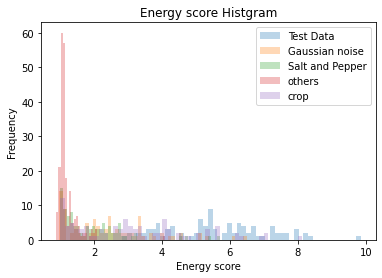

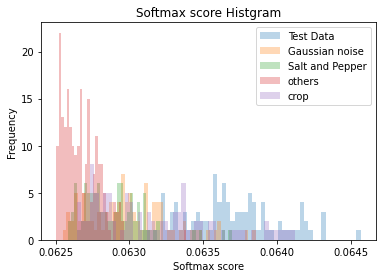

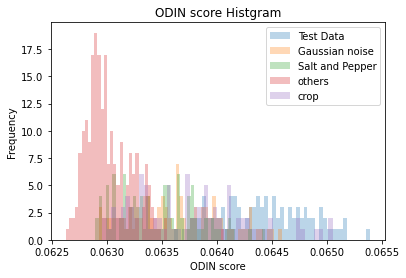

In [11]:
#model = torch.load("resnet18_gan.pth").to(device)
#model = torch.load("resnet18_gan_tune_model_best.pth").to(device)
model = torch.load("densenet_gan_tune_model.pth").to(device)
#model = torch.load("resnet18_model.pth").to(device)
data_loader = test_data_loader
resnet18_test_pro = get_max_softmax(model,data_loader,1000)
resnet18_test_energy = energy_function(model,data_loader,1)
resnet18_test_odin = ODIN(model,data_loader,1000,0.0014)


#plot_confusion_matrix(model,data_loader)

data_loader = gauss_data_loader
resnet18_gauss_pro = get_max_softmax(model,data_loader,1000)
resnet18_gauss_energy = energy_function(model,data_loader,1)
resnet18_gauss_odin = ODIN(model,data_loader,1000,0.0014)
#plot_confusion_matrix(model,data_loader)


data_loader = sp_data_loader
resnet18_sp_pro = get_max_softmax(model,data_loader,1000)
resnet18_sp_energy = energy_function(model,data_loader,1)
resnet18_sp_odin = ODIN(model,data_loader,1000,0.0014)
#plot_confusion_matrix(model,data_loader)

data_loader = others_data_loader
resnet18_others_pro = get_max_softmax(model,data_loader,1000)
resnet18_others_energy = energy_function(model,data_loader,1)
resnet18_others_odin = ODIN(model,data_loader,1000,0.0014)
#plot_confusion_matrix(model,data_loader)

data_loader = crop_data_loader
resnet18_crop_pro = get_max_softmax(model,data_loader,1000)
resnet18_crop_energy = energy_function(model,data_loader,1)
resnet18_crop_odin = ODIN(model,data_loader,1000,0.0014)
#plot_confusion_matrix(model,data_loader)


print(resnet18_test_energy.mean())
print(resnet18_gauss_energy.mean())
print(resnet18_sp_energy.mean())
print(resnet18_others_energy.mean())
print(resnet18_crop_energy.mean())

print(resnet18_test_pro.mean())
print(resnet18_gauss_pro.mean())
print(resnet18_sp_pro.mean())
print(resnet18_others_pro.mean())
print(resnet18_crop_pro.mean())

print(resnet18_test_odin.mean())
print(resnet18_gauss_odin.mean())
print(resnet18_sp_odin.mean())
print(resnet18_others_odin.mean())
print(resnet18_crop_odin.mean())

plt.figure()
plt.title("Energy score Histgram") # title
plt.ylabel("Frequency") # y label
plt.xlabel("Energy score") # x label
plt.hist(resnet18_test_energy,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_gauss_energy,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_sp_energy,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_others_energy,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_crop_energy,bins=50,histtype='stepfilled', alpha=0.3)
plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])


plt.figure()
plt.title("Softmax score Histgram") # title
plt.ylabel("Frequency") # y label
plt.xlabel("Softmax score") # x label
plt.hist(resnet18_test_pro,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_gauss_pro,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_sp_pro,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_others_pro,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_crop_pro,bins=50,histtype='stepfilled', alpha=0.3)
plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])

plt.figure()
plt.title("ODIN score Histgram") # title
plt.ylabel("Frequency") # y label
plt.xlabel("ODIN score") # x label
plt.hist(resnet18_test_odin,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_gauss_odin,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_sp_odin,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_others_odin,bins=50,histtype='stepfilled', alpha=0.3)
plt.hist(resnet18_crop_odin,bins=50,histtype='stepfilled', alpha=0.3)
plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])

In [12]:
# model = torch.load("densenet_model.pth").to(device)
# data_loader = test_data_loader
# densenet_test_pro = get_max_softmax(model,data_loader,1000)
# densenet_test_energy = energy_function(model,data_loader,1)
# densenet_test_odin = ODIN(model,data_loader,1000,0.0014)
# plot_confusion_matrix(model,data_loader)


# data_loader = gauss_data_loader
# densenet_gauss_pro = get_max_softmax(model,data_loader,1000)
# densenet_gauss_energy = energy_function(model,data_loader,1)
# densenet_gauss_odin = ODIN(model,data_loader,1000,0.0014)
# plot_confusion_matrix(model,data_loader)


# data_loader = sp_data_loader
# densenet_sp_pro = get_max_softmax(model,data_loader,1000)
# densenet_sp_energy = energy_function(model,data_loader,1)
# densenet_sp_odin = ODIN(model,data_loader,1000,0.0014)
# plot_confusion_matrix(model,data_loader)


# data_loader = others_data_loader
# densenet_others_pro = get_max_softmax(model,data_loader,1000)
# densenet_others_energy = energy_function(model,data_loader,1)
# densenet_others_odin = ODIN(model,data_loader,1000,0.0014)

# data_loader = others_data_loader
# densenet_crop_pro = get_max_softmax(model,data_loader,1000)
# densenet_crop_energy = energy_function(model,data_loader,1)
# densenet_crop_odin = ODIN(model,data_loader,1000,0.0014)


# print(densenet_test_energy.mean())
# print(densenet_gauss_energy.mean())
# print(densenet_sp_energy.mean())
# print(densenet_others_energy.mean())
# print(densenet_crop_energy.mean())

# print(densenet_test_pro.mean())
# print(densenet_gauss_pro.mean())
# print(densenet_sp_pro.mean())
# print(densenet_others_pro.mean())
# print(densenet_crop_pro.mean())

# print(densenet_test_odin.mean())
# print(densenet_gauss_odin.mean())
# print(densenet_sp_odin.mean())
# print(densenet_others_odin.mean())
# print(densenet_crop_odin.mean())


# plt.figure()
# plt.title("Energy score Histgram") # title
# plt.ylabel("Frequency") # y label
# plt.xlabel("Energy score") # x label
# plt.hist(densenet_test_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_gauss_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_sp_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_others_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_crop_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])


# plt.figure()
# plt.title("Softmax score Histgram") # title
# plt.ylabel("Frequency") # y label
# plt.xlabel("Softmax score") # x label
# plt.hist(densenet_test_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_gauss_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_sp_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_others_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_crop_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])

# plt.figure()
# plt.title("ODIN score Histgram") # title
# plt.ylabel("Frequency") # y label
# plt.xlabel("ODIN score") # x label
# plt.hist(densenet_test_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_gauss_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_sp_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_others_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(densenet_crop_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])

In [13]:
# model = torch.load("resnext50_32x4d_model.pth").to(device)
# data_loader = test_data_loader
# resnext50_32x4d_test_pro = get_max_softmax(model,data_loader,1000)
# resnext50_32x4d_test_energy = energy_function(model,data_loader,1)
# resnext50_32x4d_test_odin = ODIN(model,data_loader,1000,0.0014)
# plot_confusion_matrix(model,data_loader)


# data_loader = gauss_data_loader
# resnext50_32x4d_gauss_pro = get_max_softmax(model,data_loader,1000)
# resnext50_32x4d_gauss_energy = energy_function(model,data_loader,1)
# resnext50_32x4d_gauss_odin = ODIN(model,data_loader,1000,0.0014)
# plot_confusion_matrix(model,data_loader)


# data_loader = sp_data_loader
# resnext50_32x4d_sp_pro = get_max_softmax(model,data_loader,1000)
# resnext50_32x4d_sp_energy = energy_function(model,data_loader,1)
# resnext50_32x4d_sp_odin = ODIN(model,data_loader,1000,0.0014)
# plot_confusion_matrix(model,data_loader)


# data_loader = others_data_loader
# resnext50_32x4d_others_pro = get_max_softmax(model,data_loader,1000)
# resnext50_32x4d_others_energy = energy_function(model,data_loader,1)
# resnext50_32x4d_others_odin = ODIN(model,data_loader,1000,0.0014)

# data_loader = others_data_loader
# resnext50_32x4d_crop_pro = get_max_softmax(model,data_loader,1000)
# resnext50_32x4d_crop_energy = energy_function(model,data_loader,1)
# resnext50_32x4d_crop_odin = ODIN(model,data_loader,1000,0.0014)


# print(resnext50_32x4d_test_energy.mean())
# print(resnext50_32x4d_gauss_energy.mean())
# print(resnext50_32x4d_sp_energy.mean())
# print(resnext50_32x4d_others_energy.mean())
# print(resnext50_32x4d_crop_energy.mean())

# print(resnext50_32x4d_test_pro.mean())
# print(resnext50_32x4d_gauss_pro.mean())
# print(resnext50_32x4d_sp_pro.mean())
# print(resnext50_32x4d_others_pro.mean())
# print(resnext50_32x4d_crop_pro.mean())

# print(resnext50_32x4d_test_odin.mean())
# print(resnext50_32x4d_gauss_odin.mean())
# print(resnext50_32x4d_sp_odin.mean())
# print(resnext50_32x4d_others_odin.mean())
# print(resnext50_32x4d_crop_odin.mean())


# plt.figure()
# plt.title("Energy score Histgram") # title
# plt.ylabel("Frequency") # y label
# plt.xlabel("Energy score") # x label
# plt.hist(resnext50_32x4d_test_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_gauss_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_sp_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_others_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_crop_energy,bins=50,histtype='stepfilled', alpha=0.3)
# plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])


# plt.figure()
# plt.title("Softmax score Histgram") # title
# plt.ylabel("Frequency") # y label
# plt.xlabel("Softmax score") # x label
# plt.hist(resnext50_32x4d_test_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_gauss_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_sp_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_others_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_crop_pro,bins=50,histtype='stepfilled', alpha=0.3)
# plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])

# plt.figure()
# plt.title("ODIN score Histgram") # title
# plt.ylabel("Frequency") # y label
# plt.xlabel("ODIN score") # x label
# plt.hist(resnext50_32x4d_test_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_gauss_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_sp_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_others_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.hist(resnext50_32x4d_crop_odin,bins=50,histtype='stepfilled', alpha=0.3)
# plt.legend(['Test Data', 'Gaussian noise','Salt and Pepper','others','crop'])


In [14]:
# False positive  rate

resnet18_gauss_energy_fpr = tpr95(resnet18_test_energy,resnet18_gauss_energy,-5,23)
resnet18_sp_energy_fpr = tpr95(resnet18_test_energy,resnet18_sp_energy,-5,23)

resnet18_gauss_pro_fpr = tpr95(resnet18_test_pro,resnet18_gauss_pro,0.06,0.07)
resnet18_sp_pro_fpr = tpr95(resnet18_test_pro,resnet18_sp_pro,0.06,0.07)

resnet18_gauss_odin_fpr = tpr95(resnet18_test_odin,resnet18_gauss_odin,0.06,0.07)
resnet18_sp_odin_fpr = tpr95(resnet18_test_odin,resnet18_sp_odin,0.06,0.07)


# densenet_gauss_energy_fpr = tpr95(densenet_test_energy,densenet_gauss_energy,-5,23)
# densenet_sp_energy_fpr = tpr95(densenet_test_energy,densenet_sp_energy,-5,23)

# densenet_gauss_pro_fpr = tpr95(densenet_test_pro,densenet_gauss_pro,0.06,0.07)
# densenet_sp_pro_fpr = tpr95(densenet_test_pro,densenet_sp_pro,0.06,0.07)

# densenet_gauss_odin_fpr = tpr95(densenet_test_odin,densenet_gauss_odin,0.06,0.07)
# densenet_sp_odin_fpr = tpr95(densenet_test_odin,densenet_sp_odin,0.06,0.07)


# resnext50_32x4d_gauss_energy_fpr = tpr95(resnext50_32x4d_test_energy,resnext50_32x4d_gauss_energy,1,11)
# resnext50_32x4d_sp_energy_fpr = tpr95(resnext50_32x4d_test_energy,resnext50_32x4d_sp_energy,1,11)

# resnext50_32x4d_gauss_pro_fpr = tpr95(resnext50_32x4d_test_pro,resnext50_32x4d_gauss_pro,0.06,0.07)
# resnext50_32x4d_sp_pro_fpr = tpr95(resnext50_32x4d_test_pro,resnext50_32x4d_sp_pro,0.06,0.07)

# resnext50_32x4d_gauss_odin_fpr = tpr95(resnext50_32x4d_test_odin,resnext50_32x4d_gauss_odin,0.06,0.07)
# resnext50_32x4d_sp_odin_fpr = tpr95(resnext50_32x4d_test_odin,resnext50_32x4d_sp_odin,0.06,0.07)

In [15]:

resnet18_others_energy_fpr = tpr95(resnet18_test_energy,resnet18_others_energy,-5,23)
resnet18_crop_energy_fpr = tpr95(resnet18_test_energy,resnet18_crop_energy,-5,23)

resnet18_others_pro_fpr = tpr95(resnet18_test_pro,resnet18_others_pro,0.06,0.07)
resnet18_crop_pro_fpr = tpr95(resnet18_test_pro,resnet18_crop_pro,0.06,0.07)

resnet18_others_odin_fpr = tpr95(resnet18_test_odin,resnet18_others_odin,0.06,0.07)
resnet18_crop_odin_fpr = tpr95(resnet18_test_odin,resnet18_crop_odin,0.06,0.07)


# densenet_others_energy_fpr = tpr95(densenet_test_energy,densenet_others_energy,-5,23)
# densenet_crop_energy_fpr = tpr95(densenet_test_energy,densenet_crop_energy,-5,23)

# densenet_others_pro_fpr = tpr95(densenet_test_pro,densenet_others_pro,0.06,0.07)
# densenet_crop_pro_fpr = tpr95(densenet_test_pro,densenet_crop_pro,0.06,0.07)

# densenet_others_odin_fpr = tpr95(densenet_test_odin,densenet_others_odin,0.06,0.07)
# densenet_crop_odin_fpr = tpr95(densenet_test_odin,densenet_crop_odin,0.06,0.07)


# resnext50_32x4d_others_energy_fpr = tpr95(resnext50_32x4d_test_energy,resnext50_32x4d_others_energy,1,11)
# resnext50_32x4d_crop_energy_fpr = tpr95(resnext50_32x4d_test_energy,resnext50_32x4d_crop_energy,1,11)

# resnext50_32x4d_others_pro_fpr = tpr95(resnext50_32x4d_test_pro,resnext50_32x4d_others_pro,0.06,0.07)
# resnext50_32x4d_crop_pro_fpr = tpr95(resnext50_32x4d_test_pro,resnext50_32x4d_crop_pro,0.06,0.07)

# resnext50_32x4d_others_odin_fpr = tpr95(resnext50_32x4d_test_odin,resnext50_32x4d_others_odin,0.06,0.07)
# resnext50_32x4d_crop_odin_fpr = tpr95(resnext50_32x4d_test_odin,resnext50_32x4d_crop_odin,0.06,0.07)


In [16]:
print("resnet18_gauss_energy_fpr:",resnet18_gauss_energy_fpr)
print("resnet18_sp_energy_fpr:",resnet18_sp_energy_fpr)

print("resnet18_gauss_pro_fpr:",resnet18_gauss_pro_fpr)
print("resnet18_sp_pro_fpr:",resnet18_sp_pro_fpr)

print("resnet18_gauss_odin_fpr:",resnet18_gauss_odin_fpr)
print("resnet18_sp_odin_fpr:",resnet18_sp_odin_fpr)

# print("densenet_gauss_energy_fpr:",densenet_gauss_energy_fpr)
# print("densenet_sp_energy_fpr:",densenet_sp_energy_fpr)

# print("densenet_gauss_pro_fpr:",densenet_gauss_pro_fpr)
# print("densenet_sp_pro_fpr:",densenet_sp_pro_fpr)

# print("densenet_gauss_odin_fpr:",densenet_gauss_odin_fpr)
# print("densenet_sp_odin_fpr:",densenet_sp_odin_fpr)

# print("resnext50_32x4d_gauss_energy_fpr:",resnext50_32x4d_gauss_energy_fpr)
# print("resnext50_32x4d_sp_energy_fpr:",resnext50_32x4d_sp_energy_fpr)

# print("resnext50_32x4d_gauss_pro_fpr:",resnext50_32x4d_gauss_pro_fpr)
# print("resnext50_32x4d_sp_pro_fpr:",resnext50_32x4d_sp_pro_fpr)

# print("resnext50_32x4d_gauss_odin_fpr:",resnext50_32x4d_gauss_odin_fpr)
# print("resnext50_32x4d_sp_odin_fpr:",resnext50_32x4d_sp_odin_fpr)

resnet18_gauss_energy_fpr: 0.1742541152263375
resnet18_sp_energy_fpr: 0.04166666666666662
resnet18_gauss_pro_fpr: 0.15299479166666666
resnet18_sp_pro_fpr: 0.04166666666666666
resnet18_gauss_odin_fpr: 0.33862704918032815
resnet18_sp_odin_fpr: 0.189207650273224


In [17]:
print("resnet18_others_energy_fpr:",resnet18_others_energy_fpr)
print("resnet18_crop_energy_fpr:",resnet18_crop_energy_fpr)

print("resnet18_others_pro_fpr:",resnet18_others_pro_fpr)
print("resnet18_crop_pro_fpr:",resnet18_crop_pro_fpr)

print("resnet18_others_odin_fpr:",resnet18_others_odin_fpr)
print("resnet18_crop_odin_fpr:",resnet18_crop_odin_fpr)

# print("densenet_others_energy_fpr:",densenet_others_energy_fpr)
# print("densenet_crop_energy_fpr:",densenet_crop_energy_fpr)

# print("densenet_others_pro_fpr:",densenet_others_pro_fpr)
# print("densenet_crop_pro_fpr:",densenet_crop_pro_fpr)

# print("densenet_others_odin_fpr:",densenet_others_odin_fpr)
# print("densenet_crop_odin_fpr:",densenet_crop_odin_fpr)

# print("resnext50_32x4d_others_energy_fpr:",resnext50_32x4d_others_energy_fpr)
# print("resnext50_32x4d_crop_energy_fpr:",resnext50_32x4d_crop_energy_fpr)

# print("resnext50_32x4d_others_pro_fpr:",resnext50_32x4d_others_pro_fpr)
# print("resnext50_32x4d_crop_pro_fpr:",resnext50_32x4d_crop_pro_fpr)

# print("resnext50_32x4d_others_odin_fpr:",resnext50_32x4d_others_odin_fpr)
# print("resnext50_32x4d_crop_odin_fpr:",resnext50_32x4d_crop_odin_fpr)


resnet18_others_energy_fpr: 0.0045662100456621
resnet18_crop_energy_fpr: 0.36625514403292225
resnet18_others_pro_fpr: 0.0045662100456621
resnet18_crop_pro_fpr: 0.4147135416666667
resnet18_others_odin_fpr: 0.0045662100456621
resnet18_crop_odin_fpr: 0.46260245901639363


In [18]:
# AUROC

resnet18_gauss_energy_auroc = auroc(resnet18_test_energy,resnet18_gauss_energy,-5,23)
resnet18_sp_energy_auroc = auroc(resnet18_test_energy,resnet18_sp_energy,-5,23)

resnet18_gauss_pro_auroc = auroc(resnet18_test_pro,resnet18_gauss_pro,0.06,0.07)
resnet18_sp_pro_auroc = auroc(resnet18_test_pro,resnet18_sp_pro,0.06,0.07)

resnet18_gauss_odin_auroc = auroc(resnet18_test_odin,resnet18_gauss_odin,0.06,0.07)
resnet18_sp_odin_auroc = auroc(resnet18_test_odin,resnet18_sp_odin,0.06,0.07)


# densenet_gauss_energy_auroc = auroc(densenet_test_energy,densenet_gauss_energy,-5,23)
# densenet_sp_energy_auroc = auroc(densenet_test_energy,densenet_sp_energy,-5,23)

# densenet_gauss_pro_auroc = auroc(densenet_test_pro,densenet_gauss_pro,0.06,0.07)
# densenet_sp_pro_auroc = auroc(densenet_test_pro,densenet_sp_pro,0.06,0.07)

# densenet_gauss_odin_auroc = auroc(densenet_test_odin,densenet_gauss_odin,0.06,0.07)
# densenet_sp_odin_auroc = auroc(densenet_test_odin,densenet_sp_odin,0.06,0.07)


# resnext50_32x4d_gauss_energy_auroc = auroc(resnext50_32x4d_test_energy,resnext50_32x4d_gauss_energy,1,11)
# resnext50_32x4d_sp_energy_auroc = auroc(resnext50_32x4d_test_energy,resnext50_32x4d_sp_energy,1,11)

# resnext50_32x4d_gauss_pro_auroc = auroc(resnext50_32x4d_test_pro,resnext50_32x4d_gauss_pro,0.06,0.07)
# resnext50_32x4d_sp_pro_auroc = auroc(resnext50_32x4d_test_pro,resnext50_32x4d_sp_pro,0.06,0.07)

# resnext50_32x4d_gauss_odin_auroc = auroc(resnext50_32x4d_test_odin,resnext50_32x4d_gauss_odin,0.06,0.07)
# resnext50_32x4d_sp_odin_auroc = auroc(resnext50_32x4d_test_odin,resnext50_32x4d_sp_odin,0.06,0.07)

In [19]:
# AUROC

resnet18_others_energy_auroc = auroc(resnet18_test_energy,resnet18_others_energy,-5,23)
resnet18_crop_energy_auroc = auroc(resnet18_test_energy,resnet18_crop_energy,-5,23)

resnet18_others_pro_auroc = auroc(resnet18_test_pro,resnet18_others_pro,0.06,0.07)
resnet18_crop_pro_auroc = auroc(resnet18_test_pro,resnet18_crop_pro,0.06,0.07)

resnet18_others_odin_auroc = auroc(resnet18_test_odin,resnet18_others_odin,0.06,0.07)
resnet18_crop_odin_auroc = auroc(resnet18_test_odin,resnet18_crop_odin,0.06,0.07)


# densenet_others_energy_auroc = auroc(densenet_test_energy,densenet_others_energy,-5,23)
# densenet_crop_energy_auroc = auroc(densenet_test_energy,densenet_crop_energy,-5,23)

# densenet_others_pro_auroc = auroc(densenet_test_pro,densenet_others_pro,0.06,0.07)
# densenet_crop_pro_auroc = auroc(densenet_test_pro,densenet_crop_pro,0.06,0.07)

# densenet_others_odin_auroc = auroc(densenet_test_odin,densenet_others_odin,0.06,0.07)
# densenet_crop_odin_auroc = auroc(densenet_test_odin,densenet_crop_odin,0.06,0.07)


# resnext50_32x4d_others_energy_auroc = auroc(resnext50_32x4d_test_energy,resnext50_32x4d_others_energy,1,11)
# resnext50_32x4d_crop_energy_auroc = auroc(resnext50_32x4d_test_energy,resnext50_32x4d_crop_energy,1,11)

# resnext50_32x4d_others_pro_auroc = auroc(resnext50_32x4d_test_pro,resnext50_32x4d_others_pro,0.06,0.07)
# resnext50_32x4d_crop_pro_auroc = auroc(resnext50_32x4d_test_pro,resnext50_32x4d_crop_pro,0.06,0.07)

# resnext50_32x4d_others_odin_auroc = auroc(resnext50_32x4d_test_odin,resnext50_32x4d_others_odin,0.06,0.07)
# resnext50_32x4d_crop_odin_auroc = auroc(resnext50_32x4d_test_odin,resnext50_32x4d_crop_odin,0.06,0.07)


In [20]:
print("resnet18_gauss_energy_auroc:",resnet18_gauss_energy_auroc)
print("resnet18_sp_energy_auroc:",resnet18_sp_energy_auroc)

print("resnet18_gauss_pro_auroc:",resnet18_gauss_pro_auroc)
print("resnet18_sp_pro_auroc:",resnet18_sp_pro_auroc)

print("resnet18_gauss_odin_auroc:",resnet18_gauss_odin_auroc)
print("resnet18_sp_odin_auroc:",resnet18_sp_odin_auroc)

# print("densenet_gauss_energy_auroc:",densenet_gauss_energy_auroc)
# print("densenet_sp_energy_auroc:",densenet_sp_energy_auroc)

# print("densenet_gauss_pro_auroc:",densenet_gauss_pro_auroc)
# print("densenet_sp_pro_auroc:",densenet_sp_pro_auroc)

# print("densenet_gauss_odin_auroc:",densenet_gauss_odin_auroc)
# print("densenet_sp_odin_auroc:",densenet_sp_odin_auroc)

# print("resnext50_32x4d_gauss_energy_auroc:",resnext50_32x4d_gauss_energy_auroc)
# print("resnext50_32x4d_sp_energy_auroc:",resnext50_32x4d_sp_energy_auroc)

# print("resnext50_32x4d_gauss_pro_auroc:",resnext50_32x4d_gauss_pro_auroc)
# print("resnext50_32x4d_sp_pro_auroc:",resnext50_32x4d_sp_pro_auroc)

# print("resnext50_32x4d_gauss_odin_auroc:",resnext50_32x4d_gauss_odin_auroc)
# print("resnext50_32x4d_sp_odin_auroc:",resnext50_32x4d_sp_odin_auroc)

resnet18_gauss_energy_auroc: 0.9492187499999999
resnet18_sp_energy_auroc: 0.9820963541666669
resnet18_gauss_pro_auroc: 0.9473741319444443
resnet18_sp_pro_auroc: 0.9826388888888891
resnet18_gauss_odin_auroc: 0.9052734375000001
resnet18_sp_odin_auroc: 0.9585503472222225


In [21]:
print("resnet18_others_energy_auroc:",resnet18_others_energy_auroc)
print("resnet18_crop_energy_auroc:",resnet18_crop_energy_auroc)

print("resnet18_others_pro_auroc:",resnet18_others_pro_auroc)
print("resnet18_crop_pro_auroc:",resnet18_crop_pro_auroc)

print("resnet18_others_odin_auroc:",resnet18_others_odin_auroc)
print("resnet18_crop_odin_auroc:",resnet18_crop_odin_auroc)

# print("densenet_others_energy_auroc:",densenet_others_energy_auroc)
# print("densenet_crop_energy_auroc:",densenet_crop_energy_auroc)

# print("densenet_others_pro_auroc:",densenet_others_pro_auroc)
# print("densenet_crop_pro_auroc:",densenet_crop_pro_auroc)

# print("densenet_others_odin_auroc:",densenet_others_odin_auroc)
# print("densenet_crop_odin_auroc:",densenet_crop_odin_auroc)

# print("resnext50_32x4d_others_energy_auroc:",resnext50_32x4d_others_energy_auroc)
# print("resnext50_32x4d_crop_energy_auroc:",resnext50_32x4d_crop_energy_auroc)

# print("resnext50_32x4d_others_pro_auroc:",resnext50_32x4d_others_pro_auroc)
# print("resnext50_32x4d_crop_pro_auroc:",resnext50_32x4d_crop_pro_auroc)

# print("resnext50_32x4d_others_odin_auroc:",resnext50_32x4d_others_odin_auroc)
# print("resnext50_32x4d_crop_odin_auroc:",resnext50_32x4d_crop_odin_auroc)


resnet18_others_energy_auroc: 0.9990962709284623
resnet18_crop_energy_auroc: 0.8565538194444445
resnet18_others_pro_auroc: 0.9990487062404869
resnet18_crop_pro_auroc: 0.8351779513888888
resnet18_others_odin_auroc: 0.9988584474885843
resnet18_crop_odin_auroc: 0.8318142361111112


In [22]:
resnet18_gauss_energy_auprIn = auprIn(resnet18_test_energy,resnet18_gauss_energy,-5,23)
resnet18_sp_energy_auprIn = auprIn(resnet18_test_energy,resnet18_sp_energy,-5,23)

resnet18_gauss_pro_auprIn = auprIn(resnet18_test_pro,resnet18_gauss_pro,0.06,0.07)
resnet18_sp_pro_auprIn = auprIn(resnet18_test_pro,resnet18_sp_pro,0.06,0.07)

resnet18_gauss_odin_auprIn = auprIn(resnet18_test_odin,resnet18_gauss_odin,0.06,0.07)
resnet18_sp_odin_auprIn = auprIn(resnet18_test_odin,resnet18_sp_odin,0.06,0.07)


# densenet_gauss_energy_auprIn = auprIn(densenet_test_energy,densenet_gauss_energy,-5,23)
# densenet_sp_energy_auprIn = auprIn(densenet_test_energy,densenet_sp_energy,-5,23)

# densenet_gauss_pro_auprIn = auprIn(densenet_test_pro,densenet_gauss_pro,0.06,0.07)
# densenet_sp_pro_auprIn = auprIn(densenet_test_pro,densenet_sp_pro,0.06,0.07)

# densenet_gauss_odin_auprIn = auprIn(densenet_test_odin,densenet_gauss_odin,0.06,0.07)
# densenet_sp_odin_auprIn = auprIn(densenet_test_odin,densenet_sp_odin,0.06,0.07)


# resnext50_32x4d_gauss_energy_auprIn = auprIn(resnext50_32x4d_test_energy,resnext50_32x4d_gauss_energy,1,11)
# resnext50_32x4d_sp_energy_auprIn = auprIn(resnext50_32x4d_test_energy,resnext50_32x4d_sp_energy,1,11)

# resnext50_32x4d_gauss_pro_auprIn = auprIn(resnext50_32x4d_test_pro,resnext50_32x4d_gauss_pro,0.06,0.07)
# resnext50_32x4d_sp_pro_auprIn = auprIn(resnext50_32x4d_test_pro,resnext50_32x4d_sp_pro,0.06,0.07)

# resnext50_32x4d_gauss_odin_auprIn = auprIn(resnext50_32x4d_test_odin,resnext50_32x4d_gauss_odin,0.06,0.07)
# resnext50_32x4d_sp_odin_auprIn = auprIn(resnext50_32x4d_test_odin,resnext50_32x4d_sp_odin,0.06,0.07)


In [23]:
resnet18_others_energy_auprIn = auprIn(resnet18_test_energy,resnet18_others_energy,-5,23)
resnet18_crop_energy_auprIn = auprIn(resnet18_test_energy,resnet18_crop_energy,-5,23)

resnet18_others_pro_auprIn = auprIn(resnet18_test_pro,resnet18_others_pro,0.06,0.07)
resnet18_crop_pro_auprIn = auprIn(resnet18_test_pro,resnet18_crop_pro,0.06,0.07)

resnet18_others_odin_auprIn = auprIn(resnet18_test_odin,resnet18_others_odin,0.06,0.07)
resnet18_crop_odin_auprIn = auprIn(resnet18_test_odin,resnet18_crop_odin,0.06,0.07)


# densenet_others_energy_auprIn = auprIn(densenet_test_energy,densenet_others_energy,-5,23)
# densenet_crop_energy_auprIn = auprIn(densenet_test_energy,densenet_crop_energy,-5,23)

# densenet_others_pro_auprIn = auprIn(densenet_test_pro,densenet_others_pro,0.06,0.07)
# densenet_crop_pro_auprIn = auprIn(densenet_test_pro,densenet_crop_pro,0.06,0.07)

# densenet_others_odin_auprIn = auprIn(densenet_test_odin,densenet_others_odin,0.06,0.07)
# densenet_crop_odin_auprIn = auprIn(densenet_test_odin,densenet_crop_odin,0.06,0.07)


# resnext50_32x4d_others_energy_auprIn = auprIn(resnext50_32x4d_test_energy,resnext50_32x4d_others_energy,1,11)
# resnext50_32x4d_crop_energy_auprIn = auprIn(resnext50_32x4d_test_energy,resnext50_32x4d_crop_energy,1,11)

# resnext50_32x4d_others_pro_auprIn = auprIn(resnext50_32x4d_test_pro,resnext50_32x4d_others_pro,0.06,0.07)
# resnext50_32x4d_crop_pro_auprIn = auprIn(resnext50_32x4d_test_pro,resnext50_32x4d_crop_pro,0.06,0.07)

# resnext50_32x4d_others_odin_auprIn = auprIn(resnext50_32x4d_test_odin,resnext50_32x4d_others_odin,0.06,0.07)
# resnext50_32x4d_crop_odin_auprIn = auprIn(resnext50_32x4d_test_odin,resnext50_32x4d_crop_odin,0.06,0.07)


In [24]:
print("resnet18_gauss_energy_auprIn:",resnet18_gauss_energy_auprIn)
print("resnet18_sp_energy_auprIn:",resnet18_sp_energy_auprIn)

print("resnet18_gauss_pro_auprIn:",resnet18_gauss_pro_auprIn)
print("resnet18_sp_pro_auprIn:",resnet18_sp_pro_auprIn)

print("resnet18_gauss_odin_auprIn:",resnet18_gauss_odin_auprIn)
print("resnet18_sp_odin_auprIn:",resnet18_sp_odin_auprIn)

# print("densenet_gauss_energy_auprIn:",densenet_gauss_energy_auprIn)
# print("densenet_sp_energy_auprIn:",densenet_sp_energy_auprIn)

# print("densenet_gauss_pro_auprIn:",densenet_gauss_pro_auprIn)
# print("densenet_sp_pro_auprIn:",densenet_sp_pro_auprIn)

# print("densenet_gauss_odin_auprIn:",densenet_gauss_odin_auprIn)
# print("densenet_sp_odin_auprIn:",densenet_sp_odin_auprIn)

# print("resnext50_32x4d_gauss_energy_auprIn:",resnext50_32x4d_gauss_energy_auprIn)
# print("resnext50_32x4d_sp_energy_auprIn:",resnext50_32x4d_sp_energy_auprIn)

# print("resnext50_32x4d_gauss_pro_auprIn:",resnext50_32x4d_gauss_pro_auprIn)
# print("resnext50_32x4d_sp_pro_auprIn:",resnext50_32x4d_sp_pro_auprIn)

# print("resnext50_32x4d_gauss_odin_auprIn:",resnext50_32x4d_gauss_odin_auprIn)
# print("resnext50_32x4d_sp_odin_auprIn:",resnext50_32x4d_sp_odin_aup rIn)


resnet18_gauss_energy_auprIn: 0.941281941725169
resnet18_sp_energy_auprIn: 0.9777940406113799
resnet18_gauss_pro_auprIn: 0.9403657977232857
resnet18_sp_pro_auprIn: 0.9789892590071722
resnet18_gauss_odin_auprIn: 0.9044560655137326
resnet18_sp_odin_auprIn: 0.9591134638472236


In [25]:
print("resnet18_others_energy_auprIn:",resnet18_others_energy_auprIn)
print("resnet18_crop_energy_auprIn:",resnet18_crop_energy_auprIn)

print("resnet18_others_pro_auprIn:",resnet18_others_pro_auprIn)
print("resnet18_crop_pro_auprIn:",resnet18_crop_pro_auprIn)

print("resnet18_others_odin_auprIn:",resnet18_others_odin_auprIn)
print("resnet18_crop_odin_auprIn:",resnet18_crop_odin_auprIn)

# print("densenet_others_energy_auprIn:",densenet_others_energy_auprIn)
# print("densenet_crop_energy_auprIn:",densenet_crop_energy_auprIn)

# print("densenet_others_pro_auprIn:",densenet_others_pro_auprIn)
# print("densenet_crop_pro_auprIn:",densenet_crop_pro_auprIn)

# print("densenet_others_odin_auprIn:",densenet_others_odin_auprIn)
# print("densenet_crop_odin_auprIn:",densenet_crop_odin_auprIn)

# print("resnext50_32x4d_others_energy_auprIn:",resnext50_32x4d_others_energy_auprIn)
# print("resnext50_32x4d_crop_energy_auprIn:",resnext50_32x4d_crop_energy_auprIn)

# print("resnext50_32x4d_others_pro_auprIn:",resnext50_32x4d_others_pro_auprIn)
# print("resnext50_32x4d_crop_pro_auprIn:",resnext50_32x4d_crop_pro_auprIn)

# print("resnext50_32x4d_others_odin_auprIn:",resnext50_32x4d_others_odin_auprIn)
# print("resnext50_32x4d_crop_odin_auprIn:",resnext50_32x4d_crop_odin_auprIn)


resnet18_others_energy_auprIn: 0.9990466146852934
resnet18_crop_energy_auprIn: 0.8176996141043201
resnet18_others_pro_auprIn: 0.9989905237461975
resnet18_crop_pro_auprIn: 0.7952604199256762
resnet18_others_odin_auprIn: 0.9988700737218963
resnet18_crop_odin_auprIn: 0.7853706733337832
